In [106]:
# Useful imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.helpers import *
from src.apiQueries import getLabelFromFBID, getInfoFromTMDB, multiprocess_query

You may need to install the following libraries using pip (for the section _B) Data collection) :

- [SPARQLWrapper](https://pypi.org/project/SPARQLWrapper/): Execute SPARQL queries
- [tmdbsimple](https://pypi.org/project/tmdbsimple/): Access TMDB (The Movie Database) API

In [107]:
# pip install SPARQLWrapper
# pip install tmdbsimple

# A) Data exploration, insights and cleaning

Our project aims to analyze the _impact of casting diversity on the dynamics of roles and the performance of a film_. The purpose of this initial notebook is to become acquainted with the data, preprocess it, and generate meaningful insights from it. The key variables in our project are "diversity" and "performance." We have chosen to measure these as follows:

- Casting diversity: Ethnicity, gender, and age of actors
- Film performance: Box office earnings, ratings, languages, (and potentially the number of subsequent films).

These definitions may change over time if necessary.

We start by loading the CMU dataset files into 4 different dataframes : `movies_df`, `characters_df`, `plot_summaries_df`, `tvtropes_df`. The `helpers.py` handles all necessary formatting and casting. For easier manipulation and better consistency, we renamed all columns by prefixing them with "movie", "character" or "actor", and used a _snake_case_ formatting.

In [108]:
movies_df = load_movies()
characters_df = load_characters()
plot_summary_df = load_plot_summaries()
tvtropes_df = load_tvtropes()

### Movies dataframe

The `movies` dataframe is from the CMU movies dataset and contains details about movies:

In [109]:
movies_df.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [110]:
num_movies = movies_df.shape[0]
print(f"Number of movies: {num_movies}")

Number of movies: 81741


Our dataset appears to contain a sufficient number of samples, which will render our analysis meaningful. Now, let's examine the distribution of movies across different years.

#### Distribution of movies across different years.

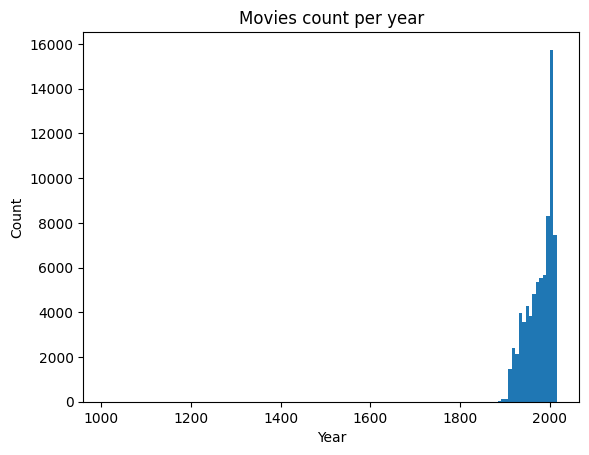

In [111]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df['movie_release_date'].str[:4].astype(float)

nb_bins = movies_df['movie_release_year'].dropna().unique().shape[0]

# Create a histogram with one bin per year
plt.hist(movies_df['movie_release_year'], bins=nb_bins)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

It seems that there are some outliers in years. Let's examine them.

In [112]:
# Show the most recent movies
movies_df.sort_values(by='movie_release_year', ascending=True).head(2)

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.00,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My...",1010.0
57963,1082508,/m/044ggd,Roundhay Garden Scene,1888,NaN,0.03,"{""/m/06ppq"": ""Silent film""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1888.0


There is only one outlier corresponding to the year 1010, which is highly unlikely. This outlier has the potential to introduce bias into our subsequent analysis, especially when we explore performance trends over time or attempt to standardize our data. Consequently, we have the option to either remove it or attempt to correct it.

According to wikipedia, the _Hunting Season_ movie has been released in 2010 : https://en.wikipedia.org/wiki/Hunting_Season_(2010_film)

Therefore, we will correct this error manually.

In [113]:
# correct the date of the movie
movies_df.loc[62836, 'movie_release_date'] = '2010-12-03'
movies_df.loc[62836, 'movie_release_year'] = 2010

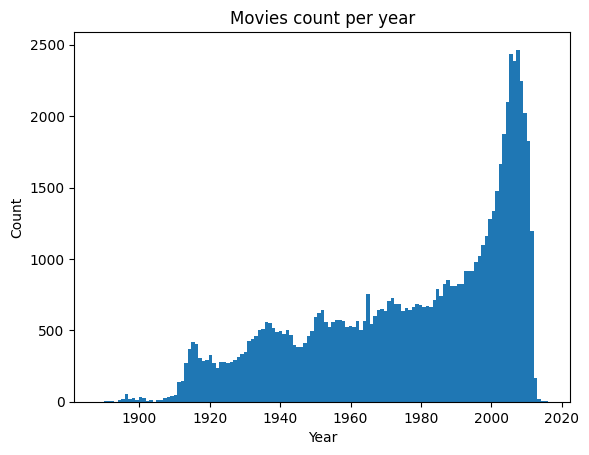

In [114]:
nb_bins = movies_df['movie_release_year'].dropna().unique().shape[0]

# Create a histogram with one bin per year
plt.hist(movies_df['movie_release_year'], bins=nb_bins)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

Now, the chart depicting the distribution of movies over time is more legible. It is evident that our dataset includes a significantly larger number of movies from 1980 to 2010 compared to the earlier period. We will keep this in mind to determine if the imbalanced nature of the dataset over time poses any issues later.

In [115]:
# Calculate the percentage of movies released after 1980
movies_after_1980 = movies_df[movies_df['movie_release_year'] > 1980]
percentage_after_1980 = (len(movies_after_1980) / len(movies_df)) * 100

print(f"Percentage of movies released after 1980: {percentage_after_1980:.2f}%")

Percentage of movies released after 1980: 49.77%


#### Missing data

Given that we assess a movie's performance based on its box office revenue and the number of languages, let's investigate whether we have a sufficient amount of data for these features.

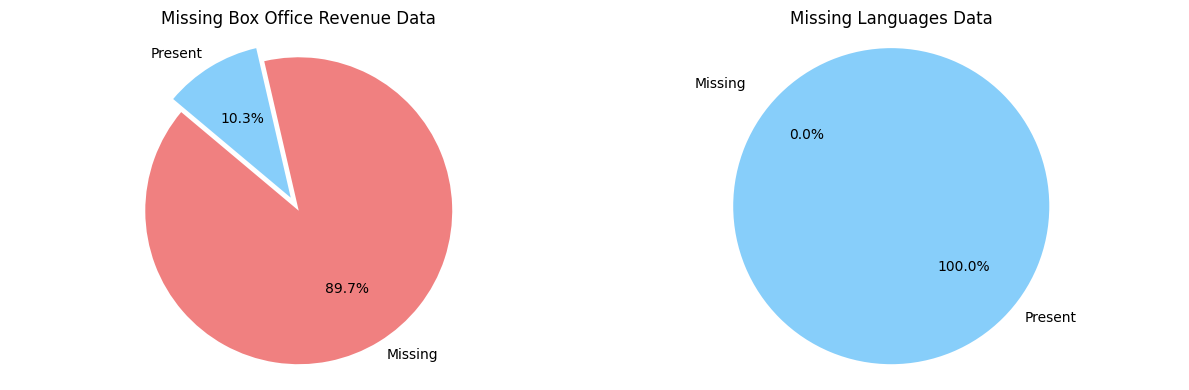

In [116]:
# Calculate missing data percentages for 'Box_office_revenue' column
missing_box_office_percentage = (movies_df['movie_box_office_revenue'].isna().sum() / len(movies_df)) * 100

# Calculate missing data percentages for 'Languages' column
missing_languages_percentage = (movies_df['movie_languages'].isna().sum() / len(movies_df)) * 100

# Create subplots for both pie charts side by side
plt.figure(figsize=(12, 4))

# First subplot (Box Office Revenue)
plt.subplot(1, 2, 1)
labels_box_office = ['Missing', 'Present']
sizes_box_office = [missing_box_office_percentage, 100 - missing_box_office_percentage]
colors_box_office = ['lightcoral', 'lightskyblue']
explode_box_office = (0.1, 0)  # Explode the "Missing" slice
plt.pie(sizes_box_office, labels=labels_box_office, colors=colors_box_office, autopct='%1.1f%%', explode=explode_box_office, startangle=140)
plt.title('Missing Box Office Revenue Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Second subplot (Languages)
plt.subplot(1, 2, 2)
labels_languages = ['Missing', 'Present']
sizes_languages = [missing_languages_percentage, 100 - missing_languages_percentage]
colors_languages = ['lightcoral', 'lightskyblue']
explode_languages = (0.1, 0)  # Explode the "Missing" slice
plt.pie(sizes_languages, labels=labels_languages, colors=colors_languages, autopct='%1.1f%%', explode=explode_languages, startangle=140)
plt.title('Missing Languages Data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()  # Ensure subplots don't overlap
plt.show()

It appears that 89.9% of the box office revenue data for movies is missing, which accounts for a significant portion of our dataset. Consequently, we will explore whether the movie ratings provide sufficient information for measuring movie performance. The movie rating will be treated in section ...

Concerning the languages, it appears that no information is missing. However, if the language count repartition is almost constant, that would mean that it's not relevant for our analyse. Therefore, let's analyze whether the language count for each movie exhibits heterogeneity.

In [117]:
# Calculate the number of unique languages for each movie
movies_df['movie_languages_count'] = movies_df['movie_languages'].apply(lambda x: len(set(x)))

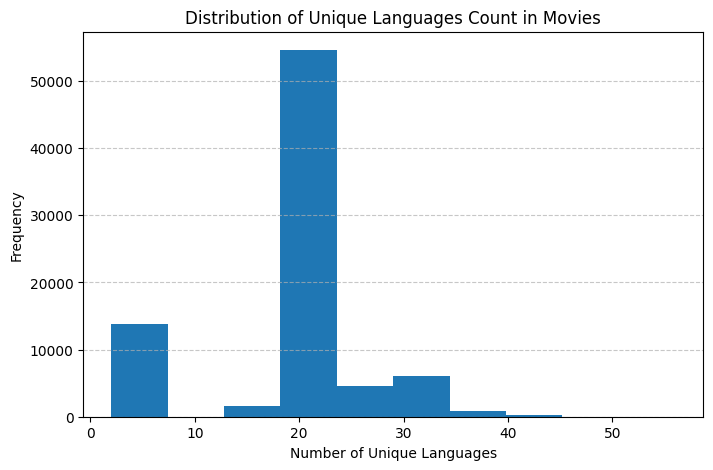

In [118]:
# Create a histogram for the number of unique languages
plt.figure(figsize=(8, 5))
plt.hist(movies_df['movie_languages_count'])
plt.xlabel('Number of Unique Languages')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Languages Count in Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Hopefully, there is a variety in the language counts, which would mean that this feature could be relevant for our research.

### Characters dataframe

The `characters` dataframe is from the CMU movies dataset and contains details about movie characters.

In [119]:
characters_df.head()

,movie_wikipedia_id,movie_freebase_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,character_actor_freebase_map_id,character_freebase_id,actor_freebase_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [120]:
total_characters = len(characters_df)
print(f"Number of characters: {total_characters}")
print(f"Number of unique actors: {len(characters_df['character_freebase_id'].unique())}", end="\n\n")

Number of characters: 450669
Number of unique actors: 183436



#### Missing data

Now, let's examine the percentage of missing data for the **Ethnicity**, **Gender**, and **Age** features in our character dataset.

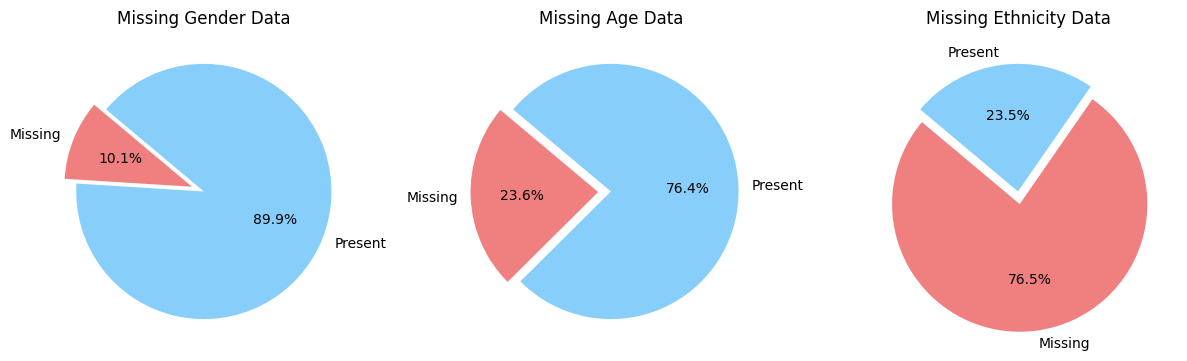

In [121]:
# Calculate missing data percentages
total_characters = len(characters_df)
missing_gender_percentage = characters_df['actor_gender'].isna().sum() / total_characters * 100
missing_age_percentage = characters_df['actor_date_of_birth'].isna().sum() / total_characters * 100
missing_ethnicity_percentage = characters_df['actor_ethnicity_freebase_id'].isna().sum() / total_characters * 100

# Create a pie chart for missing gender data
labels_gender = ['Missing', 'Present']
sizes_gender = [missing_gender_percentage, 100 - missing_gender_percentage]
colors_gender = ['lightcoral', 'lightskyblue']
explode_gender = (0.1, 0)  # Explode the "Missing" slice

plt.figure(figsize=(12, 4))  # Create a larger figure for multiple pie charts

plt.subplot(1, 3, 1)  # Create the first subplot for gender
plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, autopct='%1.1f%%', explode=explode_gender, startangle=140)
plt.title('Missing Gender Data')

# Create a pie chart for missing age data
labels_age = ['Missing', 'Present']
sizes_age = [missing_age_percentage, 100 - missing_age_percentage]
colors_age = ['lightcoral', 'lightskyblue']
explode_age = (0.1, 0)  # Explode the "Missing" slice

plt.subplot(1, 3, 2)  # Create the second subplot for age
plt.pie(sizes_age, labels=labels_age, colors=colors_age, autopct='%1.1f%%', explode=explode_age, startangle=140)
plt.title('Missing Age Data')

# Create a pie chart for missing ethnicity data
labels_ethnicity = ['Missing', 'Present']
sizes_ethnicity = [missing_ethnicity_percentage, 100 - missing_ethnicity_percentage]
colors_ethnicity = ['lightcoral', 'lightskyblue']
explode_ethnicity = (0.1, 0)  # Explode the "Missing" slice

plt.subplot(1, 3, 3)  # Create the third subplot for ethnicity
plt.pie(sizes_ethnicity, labels=labels_ethnicity, colors=colors_ethnicity, autopct='%1.1f%%', explode=explode_ethnicity, startangle=140)
plt.title('Missing Ethnicity Data')

plt.tight_layout()  # Ensure proper spacing between subplots

# Display the pie charts
plt.show()

We notice that a huge percentage of actor's ethnicity is missing. Since our project focuses primarily on actors' ethnicity, this could pose a challenge when we investigate how an actor's ethnicity affects a movie's success.
We have to keep this in mind for our research, so we try to address this data deficiency if needed.

Let's attempt to analyze the distribution of each feature to gain some insights:

**Gender (Categorical)**

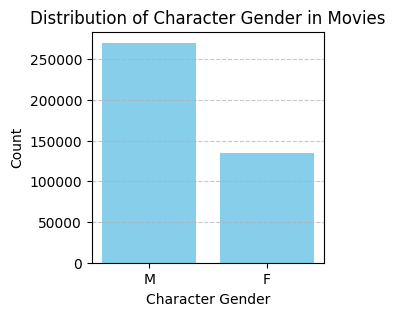

In [122]:
gender_counts = characters_df['actor_gender'].value_counts()

plt.figure(figsize=(3, 3))
plt.bar(gender_counts.index, gender_counts.values, color='skyblue')
plt.xlabel('Character Gender')
plt.ylabel('Count')
plt.title('Distribution of Character Gender in Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

There are approximately twice as many male characters as female characters. However, it's important to clarify that our focus is on the characters themselves rather than the actors portraying them. It would be valuable to conduct a more in-depth analysis to determine whether the distribution of characters aligns with the distribution of actors. This analysis would help us determine if the observed gender disparity is a result of fewer women being involved in the film industry or if roles are simply being unequally assigned.

**Age (Numerical)**

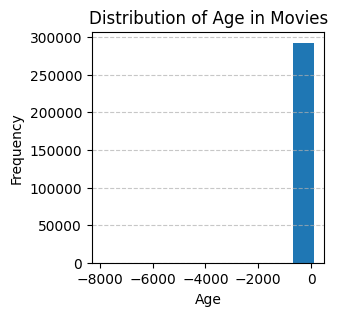

In [123]:
character_ages = characters_df[characters_df['actor_age_at_movie_release'].notna()]['actor_age_at_movie_release']

plt.figure(figsize=(3, 3))
plt.hist(character_ages)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age in Movies')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

We can observe instances of negative ages that appear to be inconsistent. To better understand their prevalence, we will determine their proportion within the dataset and subsequently remove them as they are considered erroneous data.

In [124]:
# Calculate the percentage of characters with a negative age
total_characters = len(characters_df)
negative_age_characters = len(characters_df[characters_df['actor_age_at_movie_release'] < 0])
percentage_negative_age = (negative_age_characters / total_characters) * 100

print(f"Percentage of characters with a negative age: {percentage_negative_age:.2f}%")

Percentage of characters with a negative age: 0.08%


In [125]:
# Drop characters with a negative age in place
characters_df.drop(characters_df[characters_df['actor_age_at_movie_release'] < 0].index, inplace=True)

In [126]:
total_characters = len(characters_df)
print(f"Number of characters after cleaning: {total_characters}")
print(f"Number of unique actors after cleaning: {len(characters_df['character_freebase_id'].unique())}", end="\n\n")

Number of characters after cleaning: 450288
Number of unique actors after cleaning: 183372



**Ethnicity (Categorical)**

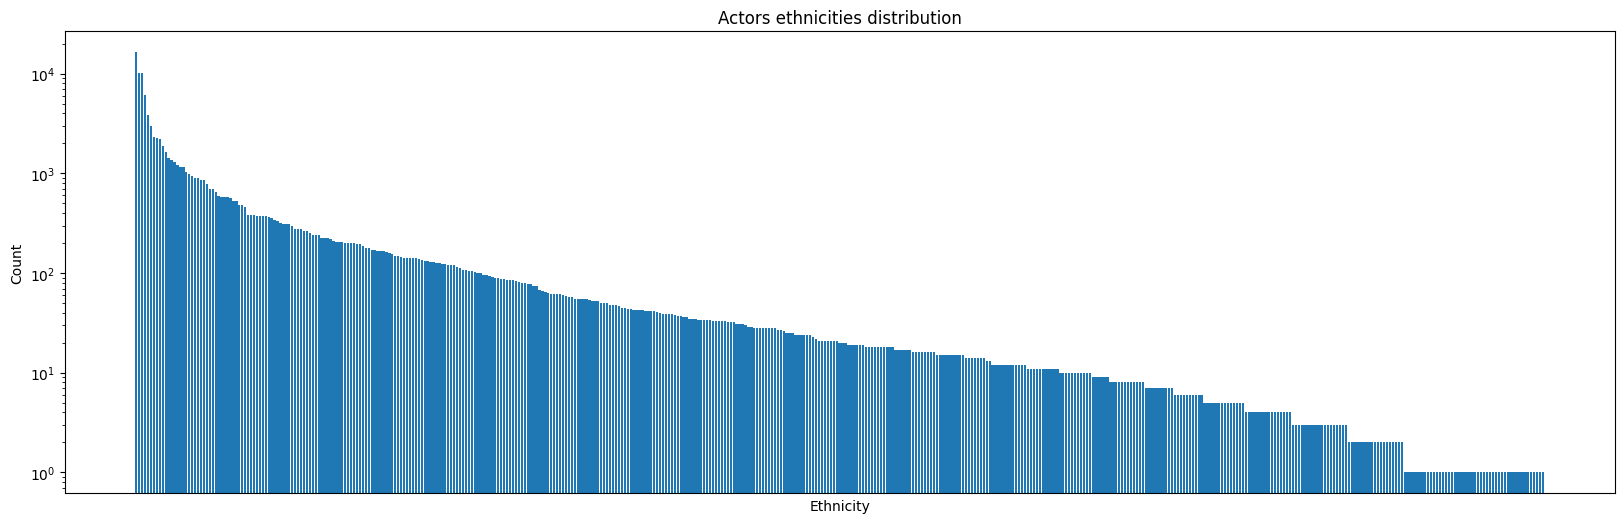

In [127]:
actors_ethnicities = characters_df.groupby(by='actor_ethnicity_freebase_id')["actor_ethnicity_freebase_id"].count().sort_values(ascending=False)

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities.values, label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

The distribution of ethnicities among the characters exhibits significant diversity. While some ethnicities are sparsely represented, others have a notably larger presence in the dataset.

### Plot summaries

The `plot` dataframe comes from the CMU dataset and contains a summary of the plot of a given movie.

In [128]:
plot_summary_df.head()

,movie_wikipedia_id,movie_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [129]:
total_plot = len(plot_summary_df)
print(f"Number of plot summaries loaded: {total_plot}")

# Compute the number of movies without plot summaries
movies_with_summary = movies_df[movies_df['movie_wikipedia_id'].isin(plot_summary_df['movie_wikipedia_id'])]
percentage_with_summary = (len(movies_with_summary) / len(movies_df)) * 100

# Print the percentage of movies without plot summaries
print(f"Percentage of movies with plot summaries: {percentage_with_summary:.2f}%")

Number of plot summaries loaded: 42306
Percentage of movies with plot summaries: 51.64%


### Tvtropes dataframe

The `tvtropes` DataFrame is derived from the CMU dataset and includes records of character types along with the corresponding actors who portray those characters.

In [130]:
tvtropes_df.head()

,character_type,character_name,movie_name,character_actor_freebase_map_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [131]:
total_tvtropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tvtropes}")

unique_character_types = len(tvtropes_df["character_type"].unique())
print(f"Number of unique character types: {unique_character_types}")

Number of tropes loaded: 501
Number of unique character types: 72


# B) Data collection

Since we aim to get a better understanding of our data, we make use of some online apis to enrich our data. Firstly, as said before, we aim to assess the performance of a movie user ratings. Since those are not available on the provided CMU dataset, we make use of a data fetcher that will try to get as much valuable information as possible.

## TMDB 

TMDB is a public movie database that contains information about numerous movies and offers a free access to an api that allows to extract information about movies, such as ratings from the platform, budgets if available and more. Unfortunately, they recently started to add wikipedia id information inside the movies descriptions but their database seems still very empty in that regard. Another problem that is faced from their api is that it allows to query movie informations for one movie at a time. 

Our proposed solution to this problem was to develop a movie matching algorithm that first queries all movie titles in the database that contains the name of the movie we're looking for. Then, we gather information about all these movies (one query at a time) and we keep the entry that has an exact title match as well as a similar duration (+-3min). The extracted data consists of the average ratings of the movies, the number of votes and, the budgets if available. Since some of these informations aren't public or missing. Lacking entries are filled with zeros.

In [132]:
# # Load the api key to perform some queries on the movie database
# with open('api_keys/tmdbkey.txt','r') as file:
#     key = file.readline()

# # Extract the relevant information needed for queries
# to_search = movies_df[['movie_name','movie_runtime']].copy()

# # Since the api allows single queries only, we make use of multiprocesses to accelerate
# # the process. ~24h -> 6h

# ## Here we define the task to multiprocess and extract the informations we want.

# # def task(chunk, key):
# #     return getInfoFromTMDB(movie_list = chunk,key = key, verbose=False)
# # extracted_movie_info = multiprocess_query(movie_list=to_search,api_key=key, nb_workers=5,task = task)
# # extracted_movie_info.to_csv('generated/extra_TMDB_info.csv')

In [133]:
# Get the generated dataset and remove a duplicate index column
extracted_movie_info = pd.read_csv('generated/TMDB_extra_info.csv').iloc[:,1:]
print("Informations found for {} movies out of {}"
      .format(len(extracted_movie_info),len(movies_df)))
extracted_movie_info.head(4)

Informations found for 40647 movies out of 81741


,title,vote_average,vote_counts,budget
0,Ghosts of Mars,5.125,982,28000000
1,Brun bitter,0.000,0,0
2,White Of The Eye,5.742,64,0
3,A Woman in Flames,5.300,13,0


First analysis on the rating

In [134]:
# We filter out movies that have a small amout of votes, let's say 30 is representative enough
movie_ratings = extracted_movie_info[extracted_movie_info['vote_counts'] > 30].copy()
movie_ratings = movie_ratings[['title','vote_average','vote_counts']]
print("movies with more that 30 ratings : {}".format(len(movie_ratings)))

movies with more that 30 ratings : 13906


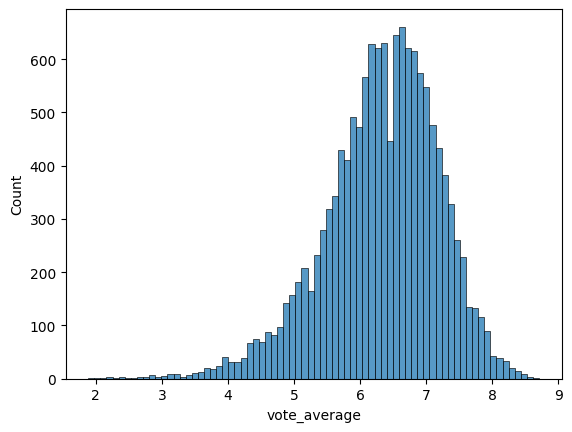

Mean average rating 6.32
Median average rating 6.40


In [135]:
#Show the distribution of votes and some relevant information
sns.histplot(data=movie_ratings,x='vote_average')
plt.show()

print("Mean average rating {:.2f}\nMedian average rating {:.2f}"
      .format(movie_ratings['vote_average'].mean(),movie_ratings['vote_average'].median()))

The distribution seems to mostly follow a gaussian distribution. Let's investigate that a bit more.

In [136]:
from scipy.stats import normaltest
normaltest(movie_ratings['vote_average'])

NormaltestResult(statistic=1057.8150882573825, pvalue=1.9877975358998404e-230)

The p-value is way under 0.05, which means that we reject the null hypothesis that the samples were drawn from a normal distribution.

Now let's have a look at the few budgets extracted from TMDB

In [137]:
# Extract movies that contain budgets above a million to generate a dataframe that allows
# comparisons of movies developed under what is considered high budgets
movies_budgets = extracted_movie_info[extracted_movie_info["budget"] > 1e6].copy()
movies_budgets = movies_budgets[['title','budget']]
min_budget =movies_budgets['budget'].min()
max_budget = movies_budgets['budget'].max()
print('number of movies that have a budget higher than 1 Million : {}'
      .format(len(movies_budgets)))

number of movies that have a budget higher than 1 Million : 5606


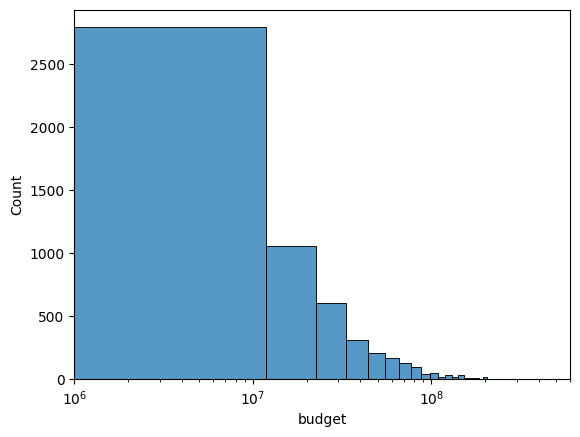

The median movie has a budget of 12000000.0
The cheapest movies costed 1001000
The most expensive movie costed 540000000


In [138]:
## Get the informations of the highest and smallest budgets for movies above a million
## and plot the overall distribution
sns.histplot(data=movies_budgets,x='budget',bins=50)
plt.xlim([1e6,6e8])
plt.xscale('log')
plt.show()
print('The median movie has a budget of {}'.format(movies_budgets['budget'].median()))
print('The cheapest movies costed {}\nThe most expensive movie costed {}'
      .format(min_budget,max_budget))

<Axes: xlabel='budget', ylabel='Proportion'>

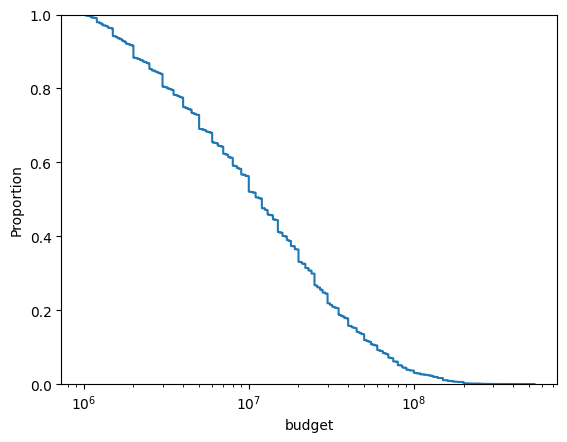

In [139]:
## Plot a ccdf to get a better idea of the budget distribution above a million
sns.ecdfplot(data=movies_budgets,x='budget',complementary=True,log_scale=True)

We remark that the distribution of budgets above 1 million doesn't necessarily follow a power law but it makes it very clear that a vast majority of movies are developed with a budgets under 10 millions. 

This data will allow us to compare movies that are still considered high budgets and help us making coherent grouping when trying to perform causal analysis on the impact diversity has.
This data may be important because comparing only box office revenues could bring a consequent bias.

## Wikipedia database

The dataset is composed of numerous entries in FreeBaseID format. Those are not very verbose and don't allow to understand exactly what is represented by these features. We therefore make use of the wikipedia database to extract the related labels of those ids.

In [140]:
FB_ids = characters_df['actor_ethnicity_freebase_id'].dropna().unique()

In [141]:
label_ethnicity_df = getLabelFromFBID(id_list=FB_ids)
label_ethnicity_df.rename(columns={'freebaseID.value' :'actor_ethnicity_freebase_id',
                                   'sLabel.value' : 'actor_ethnicity'},inplace=True)
label_ethnicity_df.head(4)

,actor_ethnicity_freebase_id,actor_ethnicity
0,/m/0790v,Slavs
1,/m/03kbr,Hindu
2,/m/01km_m,Slovenes
3,/m/013y54,Han Chinese people


A very interesting aspect we note here is that ethnicities in that case can be defined more precisely that solely using peoples country of origin, which is a richer concept and good news for the analysis

# C) Data generation from given datasets

This section is designated for creating the basic Data Frames that will be used in our research.

### 1) Movies, Characters, Ethnicities

Previously we saw that a lot of ethnicities were missing, which would made us lose a lot of information during the merging. Therefore we will generate 2 dataframes : 

- `movie_characters_df` : Will be usefull when analyse the age and gender diversity
- `movie_characters_ethnicity_df` : Will be usefull when analysing the ethnicity disparity.
    
Only the second one will suffer from lack of data.

In [142]:
# Merging the 'movies_df' and 'characters_df' DataFrames using an inner join on the 'Wikipedia_ID' and 'Wikipedia_movie_ID' columns

movie_characters_df = pd.merge(movies_df, characters_df, on=['movie_wikipedia_id', 'movie_freebase_id', 'movie_release_date'], how='inner')
movie_characters_df.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,...,character_name,actor_date_of_birth,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,character_actor_freebase_map_id,character_freebase_id,actor_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [143]:
# Merging with the ethnicity label
movie_characters_ethnicity_df = pd.merge(movie_characters_df, label_ethnicity_df, on="actor_ethnicity_freebase_id", how='inner')
movie_characters_ethnicity_df.head()

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,...,actor_date_of_birth,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,character_actor_freebase_map_id,character_freebase_id,actor_freebase_id,actor_ethnicity
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,...,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,African Americans
2,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,...,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp,African Americans
3,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2001.0,...,1970-09-11,F,1.650,/m/0x67,Taraji P. Henson,30.0,/m/0jtx5t,/m/03jnxj_,/m/0blbxk,African Americans
4,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,123.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2001.0,...,1978-12-30,M,1.797,/m/0x67,Tyrese Gibson,22.0,/m/0jtx5h,/m/03jnxf4,/m/01l1b90,African Americans


In [144]:
# Display the shape of the 'movie_characters_df' DataFrame
print("Shape of 'movie_characters_df':", movie_characters_df.shape)
print("Shape of 'movie_characters_ethnicity_df':", movie_characters_ethnicity_df.shape)

Shape of 'movie_characters_df': (450273, 21)
Shape of 'movie_characters_ethnicity_df': (102934, 22)


There are approximately four times as many samples in the `movie_characters_df` compared to the `movie_characters_ethnicity_df`. Therefore, we can confidently conclude that it is necessary to store both dataframes.

Finally, we postpone the removal of `NaN` values until later in the research. This way, we can eliminate the `NaN` values specifically from the feature that is relevant to each step, ensuring that we do not discard valuable data unnecessarily.

Now we can store our datasets in csv files, but we should keep only relevant columns !

In [145]:
# List of columns to keep, in specific order for better readability.
columns_to_keep_no_ethnicity = [
    'movie_wikipedia_id',
    'movie_freebase_id',
    'movie_name',
    'movie_release_year',
    'movie_languages_count',
    'movie_box_office_revenue',
    'character_freebase_id',
    'actor_freebase_id',
    'character_actor_freebase_map_id',
    'character_name',
    'actor_name',
    'actor_gender',
    'actor_age_at_movie_release',
]

columns_to_keep_ethnicity = columns_to_keep_no_ethnicity + ['actor_ethnicity']

print(f"Number of columns of movie_characters_df before filtering: {movie_characters_df.shape[1]}")
movie_characters_df = movie_characters_df[columns_to_keep_no_ethnicity]
print(f"Number of columns of movie_characters_df after filtering: {movie_characters_df.shape[1]}")

print()

print(f"Number of columns of movie_characters_ethnicity_df before filtering: {movie_characters_ethnicity_df.shape[1]}")
movie_characters_ethnicity_df = movie_characters_ethnicity_df[columns_to_keep_ethnicity]
print(f"Number of columns of movie_characters_ethnicity_df after filtering: {movie_characters_ethnicity_df.shape[1]}")

Number of columns of movie_characters_df before filtering: 21
Number of columns of movie_characters_df after filtering: 13

Number of columns of movie_characters_ethnicity_df before filtering: 22
Number of columns of movie_characters_ethnicity_df after filtering: 14


In [146]:
# Save the generated data frames in cvs file
movie_characters_df.to_csv('generated/movie_characters.csv', index=False)
movie_characters_ethnicity_df.to_csv('generated/movie_characters_ethnicity.csv', index=False)

### 2) Movies, Characters, Plots, TVtropes

Now we will generate a dataframe with movies, characters and plots. This one will be used in our analysis of stereotypes associated with roles and the significance of these roles.

In [147]:
# Merging the 'movie_characters_df' and 'plot_summary_df' DataFrames using an inner join on the 'Wikipedia_ID' and 'Wikipedia_movie_ID' columns

movie_characters_plot_df = pd.merge(plot_summary_df, movie_characters_df, how='inner')
movie_characters_plot_tvtropes_df = pd.merge(movie_characters_plot_df, tvtropes_df, how='inner')

movie_characters_plot_tvtropes_df.head()

,movie_wikipedia_id,movie_plot,movie_freebase_id,movie_name,movie_release_year,movie_languages_count,movie_box_office_revenue,character_freebase_id,actor_freebase_id,character_actor_freebase_map_id,character_name,actor_name,actor_gender,actor_age_at_movie_release,character_type
0,6002183,"In the Jungle of Nool, a tiny dust speck is pu...",/m/0fk25m,Horton Hears a Who!,2008.0,22,297138014.0,/m/04xnbs,/m/0lx2l,/m/05tgl99,Horton the Elephant,Jim Carrey,M,46.0,warrior_poet
1,45772,"On November 25, 1975, Rocky Balboa is introd...",/m/0cf08,Rocky,1976.0,22,225000000.0,/m/0cg655,/m/0234pg,/m/0k2n0d,Apollo Creed,Carl Weathers,M,28.0,arrogant_kungfu_guy
2,1238102,"The film opens in the Bronx, where The Lieuten...",/m/04l40p,Bad Lieutenant,1992.0,27,2019469.0,/m/0bdwp2l,/m/0klh7,/m/0jtz28,The Lieutenant,Harvey Keitel,M,53.0,dirty_cop
3,133688,The Piano tells the story of a mute Scotswoman...,/m/0_b9f,The Piano,1993.0,30,40157856.0,/m/0h2qv1_,/m/01ckhj,/m/0k63tb,Alisdair Stewart,Sam Neill,M,45.0,crazy_jealous_guy
4,77223,Tony Wendice is an ex-professional tennis play...,/m/0k7tq,Dial M for Murder,1954.0,22,6000000.0,/m/0528dy7,/m/0f0p0,/m/0jx7qr,Tony Wendice,Ray Milland,M,47.0,crazy_jealous_guy


In [148]:
# Display the shape of the generated dataframes
print("Shape of 'movie_characters_plot_df':", movie_characters_plot_df.shape)
print("Shape of 'movie_characters_plot_tvtropes_df':", movie_characters_plot_tvtropes_df.shape)

Shape of 'movie_characters_plot_df': (308257, 14)
Shape of 'movie_characters_plot_tvtropes_df': (501, 15)


Again there is a huge lose of data for the `movie_characters_plot_tvtropes_df`. Therefore we will store both dataframes.
Moreover, as these dataframe were generated from the `movie_characters`, we notice that we don't need to filter their columns again.

In [149]:
movie_characters_plot_df.to_csv('generated/movie_characters_plot.csv', index=False)
movie_characters_plot_tvtropes_df.to_csv('generated/movie_characters_plot_tvtropes.csv', index=False)

# D) Test our generated datasets

### 1) Movies, Characters, Ethnicities

In [150]:
# Load our generated datasets
movie_characters_test_df = pd.read_csv('generated/movie_characters.csv')
movie_characters_ethnicity_test_df = pd.read_csv('generated/movie_characters_ethnicity.csv')

Let's get some insights from the ethnicity repartition.

C:\Users\Louis\AppData\Local\Temp\ipykernel_22696\2304411325.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20_ethnicities.index, y=top_20_ethnicities.values, palette='viridis')


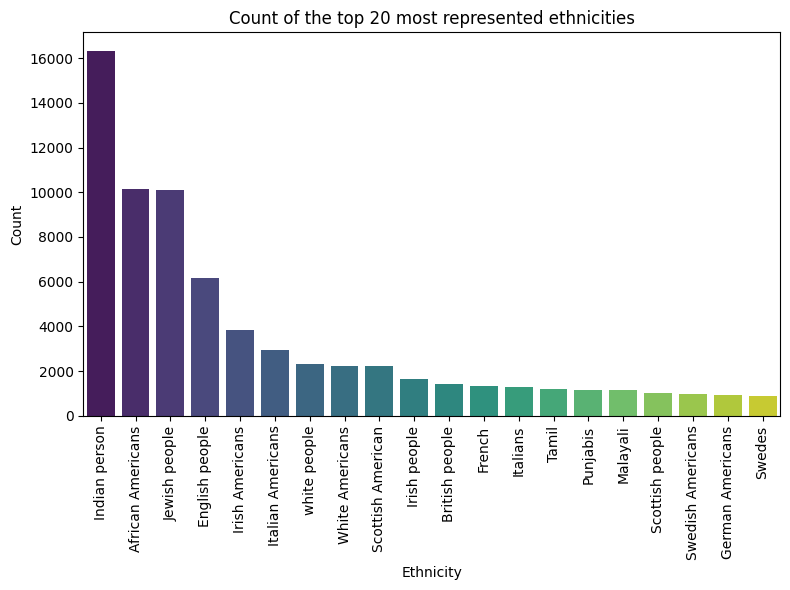

In [151]:
# Compute and sort the ethnicity distribution
ethnicity_distribution = movie_characters_ethnicity_test_df['actor_ethnicity'].value_counts()
sorted_ethnicity_distribution = ethnicity_distribution.sort_values(ascending=False)

# Keep only the top 20 values
top_20_ethnicities = sorted_ethnicity_distribution.head(20)

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=top_20_ethnicities.index, y=top_20_ethnicities.values, palette='viridis')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Count of the top 20 most represented ethnicities')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the bar chart
plt.tight_layout()
plt.show()

The distribution appears to be heterogeneous, offering us the chance to make assumptions about the more prevalent and less common ethnicities. It's important to note that this first chart reflects the ethnicities for each the characters. Therefore, it's possible for a single actor to contribute to the chart multiple times.

Let's get some insights from the gender repartition. This time we will use the `movie_characters_test_df` so we use the maximum data.

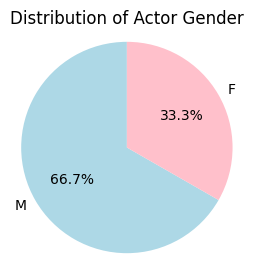

In [152]:
# Calculate the gender distribution
gender_distribution = movie_characters_test_df['actor_gender'].value_counts()

# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie(gender_distribution, labels=gender_distribution.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'pink'])
plt.title('Distribution of Actor Gender')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular

# Show the pie chart
plt.show()

Finally, let's get some insights from the age repartition, again on the `movie_characters_test_df`.

C:\Users\Louis\AppData\Local\Temp\ipykernel_22696\1679627518.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_distribution.index.astype(int), y=age_distribution.values, palette='viridis')


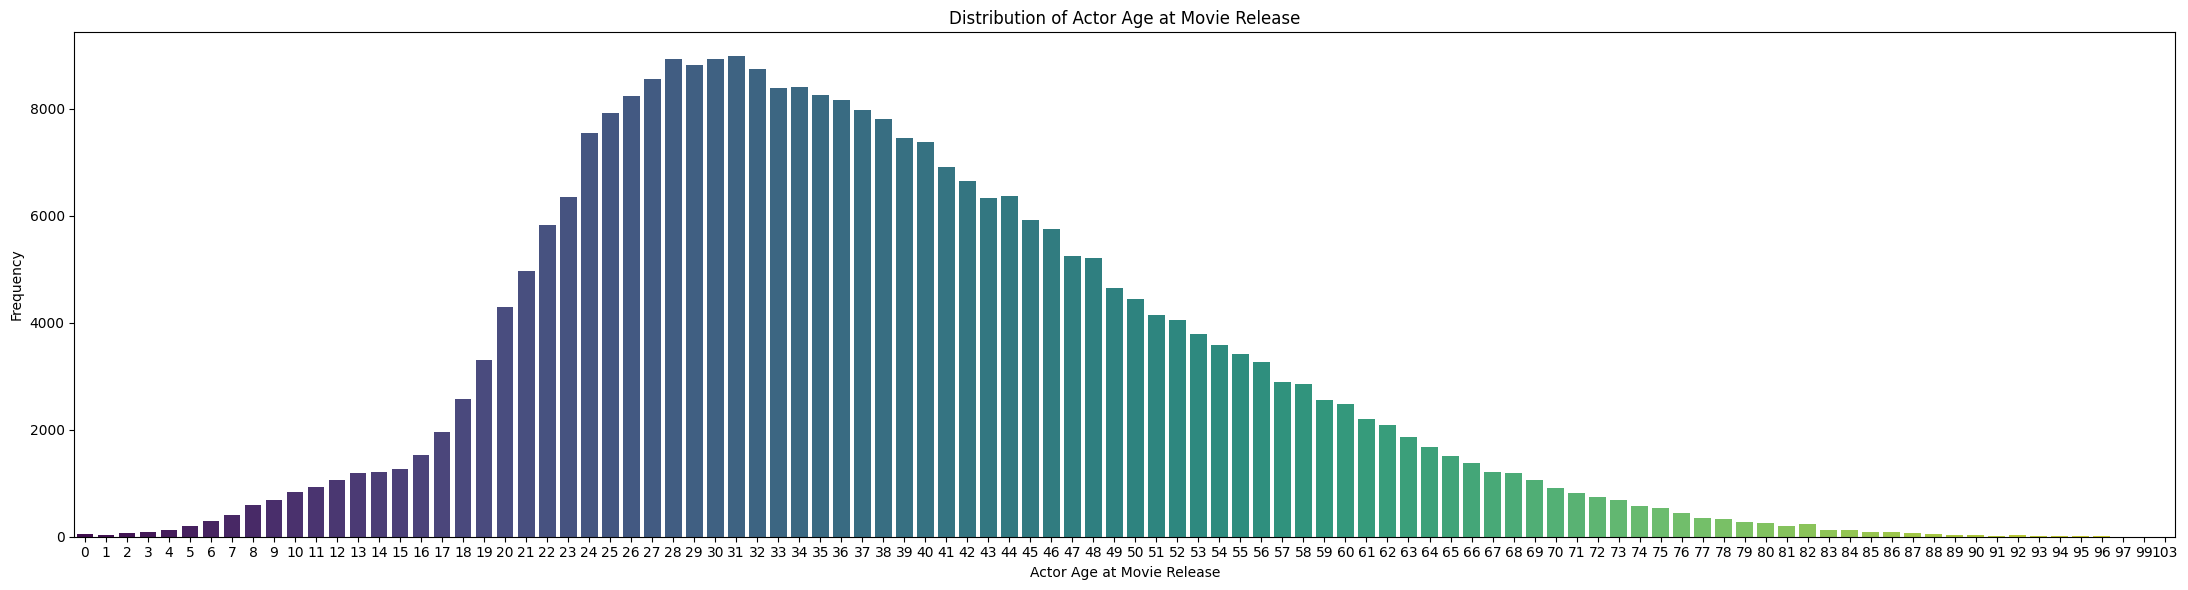

In [153]:
# Calculate the age distribution
age_distribution = movie_characters_test_df['actor_age_at_movie_release'].value_counts()

# Create a histogram
plt.figure(figsize=(22, 6))
sns.barplot(x=age_distribution.index.astype(int), y=age_distribution.values, palette='viridis')
plt.xlabel('Actor Age at Movie Release')
plt.ylabel('Frequency')
plt.title('Distribution of Actor Age at Movie Release')

# Show the histogram
plt.tight_layout()
plt.show()

### 2) Movies, Characters, Plots, TVtropes

In [154]:
# Load our generated datasets
movie_characters_plot_df = pd.read_csv('generated/movie_characters_plot.csv')
movie_characters_plot_tvtropes_df = pd.read_csv('generated/movie_characters_plot_tvtropes.csv')

Let's try an example on the movie _"Pirates of the Caribbean: Dead Man's Chest"_

In [155]:
# The names of the characters in the movie_characters_plot_tvtropes_df dataframes are :
unique_characters = movie_characters_plot_df[movie_characters_plot_df['movie_name'] == "Pirates of the Caribbean: Dead Man's Chest"]["character_name"].unique()
print("The names of the characters in the movie 'Pirates of the Caribbean: Dead Man's Chest' are:")
print(unique_characters)

The names of the characters in the movie 'Pirates of the Caribbean: Dead Man's Chest' are:
['Cutler Beckett' 'Captain Jack Sparrow' 'Will Turner' 'Elizabeth Swann'
 'Norrington' 'Davy Jones' 'Governor Weatherby Swann' 'Pintel' 'Ragetti'
 'Joshamee Gibbs' 'Cotton' 'Bootstrap Bill Turner' 'Tia Dalma' 'Marty'
 'Mercer' 'Captain Bellamy' 'Scarlett' 'Leech' 'Very Old Man'
 'Hector Barbossa']


C:\Users\Louis\AppData\Local\Temp\ipykernel_22696\3999814322.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


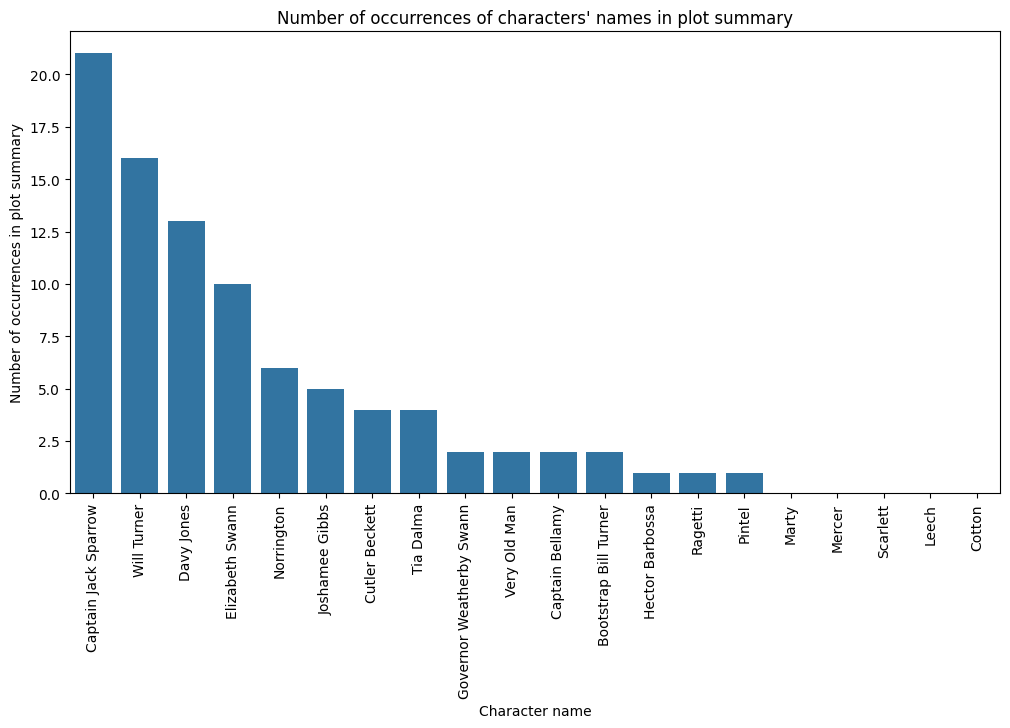

In [156]:
# Example our generated dataframe with Pirate of the Caribbean
pirate_df = movie_characters_plot_df[movie_characters_plot_df['movie_name'] == "Pirates of the Caribbean: Dead Man's Chest"].copy()

# Compute the frequency of apparition of each character in Pirate of the Caribbean in the plot summary
pirate_df['frequency_apparition'] = pirate_df.apply(lambda row: compute_apparition_frequency(row['character_name'], row['movie_plot']), axis=1)

unique_pirate_df = pirate_df.drop_duplicates(subset="actor_name", keep="first")
unique_pirate_df = unique_pirate_df.sort_values(by="frequency_apparition", ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 6))
plot = sns.barplot(x=unique_pirate_df['character_name'], y=unique_pirate_df['frequency_apparition'])

# Rotate the x-axis labels by 90 degrees
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.xlabel('Character name')
plt.ylabel('Number of occurrences in plot summary')
plt.title("Number of occurrences of characters' names in plot summary")

plt.show()

This chart relies on the performance of the function responsible for calculating the occurrences. While there is room for potential improvements in this function in the future, it currently appears to be functioning quite effectively.